In [1]:
using Plots
using DifferentialEquations
using Interpolations
using Random
using Distributions
using NLopt
using Dierckx
using LaTeXStrings
using LinearAlgebra
using StatsPlots
using KernelDensity
using Printf
gr();

In [2]:
plot_font = "Computer Modern"
default(fontfamily=plot_font,linewidth=1,framestyle=:box,label=nothing,grid=true)
default(xguidefontsize=10,yguidefontsize=10,xtickfontsize=10,ytickfontsize=10)
default(palette = palette(:Blues))

In [3]:
# return the model solution
function model(t,T0,a)
    y=zeros(length(t))
    T(t) = a[1]+(T0-a[1])*exp(-a[2]*t)
    for i in 1:length(t) 
        y[i] = T(t[i])
    end 
    return y
end;

In [4]:
Tend=100 # final time
k=0.05 # heat transfer coefficient
Ta=20.0 # ambient temperature
T0=180.0 # initial temperature - known 
σ=8.0 # noise strength
a=zeros(2) # parameter vector
t=LinRange(0,Tend,11)
tt=LinRange(0,Tend,101)
Ta_max=60 # maximum of Ta prior
k_max=1; # maximum of k prior

In [5]:
# generate the data
data=model(t,T0,[Ta,k])+[0; σ*randn(length(t)-1)]
# plot the data
p1=scatter(t,data,mc=4,msc=:match,label=false)
# plot the model solution
p1=plot!(tt,model(tt,T0,[Ta,k]),color=5,lw=2)
p1=plot!(xlabel=L"t",ylabel=L"T(t)",xlims=(t[1]-1,t[end]+1),ylims=(0,200),
    xticks=([0,25,50,75,100],[L"0", L"25", L"50", L"75", L"100"]),
    yticks=([0,50,100,150,200],[L"0", L"50", L"100", L"150",L"200"]),label=false);

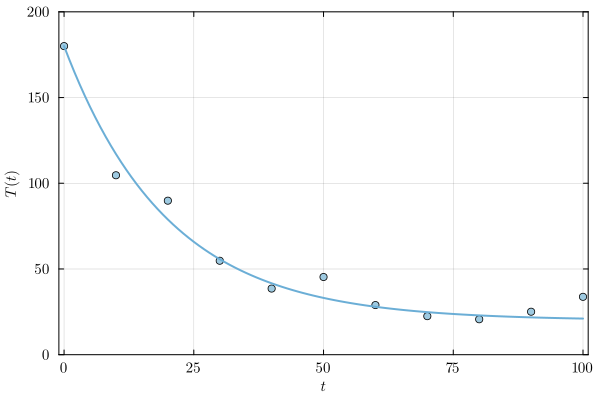

In [6]:
display(p1);

In [7]:
# compute the sum squared distance between the data and the model solution
function distance(data,T0,a,σ)
    y=zeros(length(t))
    # compute the noisy model solution
    noisy_model=model(t,T0,a)+[0; σ*randn(length(t)-1)]
    y=sum((data-noisy_model).^2);
    return y
end;

In [8]:
# compute the loglikelihood
function loglhood(data,T0,a,σ)
    y=zeros(length(t))
    y=model(t,T0,a);
    e=0;
    dist=Normal(0,σ);
    e=loglikelihood(dist,data-y) 
    return sum(e)
end;

In [9]:
# find the MLE
function Optimise(fun,θ₀,lb,ub)    
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_NELDERMEAD,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = optimize(opt,θ₀)
    return res[[2,1]]
end;

function funmle(a)
    return loglhood(data,T0,a,σ)
end;

Tamin=0.0
Tamax=100.0
kmin=0.0
kmax=1.0

θG=[20,0.05]
lb=[Tamin,kmin]
ub=[Tamax,kmax]
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub)
Tamle=xopt[1];
kmle=xopt[2];
Tmle(t)=xopt[1]+(T0-xopt[1])*exp(-xopt[2]*t);
@printf("MLE: Ta = %0.5f, k = %0.5f \n",Tamle,kmle)

  0.085959 seconds (433.64 k allocations: 24.316 MiB, 8.74% gc time, 97.77% compilation time)
MLE: Ta = 24.82034, k = 0.05339 


In [10]:
# calculate the posterior using ABC with a fixed tolerance, accepting fixed number of samples
@time begin

    # initialise sampler variables
    ϵ=1500.0
    number_samples=Int(1.0e5)
    
    Ta_accepted_samples=zeros(Float64,number_samples)
    k_accepted_samples=zeros(Float64,number_samples)

    global ii=1
    while ii<=number_samples
        # sample from prior distribution
        Ta_accepted_samples[ii]=rand(Uniform(0,Ta_max))
        k_accepted_samples[ii]=rand(Uniform(0,k_max))
        # if model and data are sufficiently close, accept the sample into the posterior distribution
        if distance(data,T0,[Ta_accepted_samples[ii],k_accepted_samples[ii]],σ)<ϵ
            ii=ii+1
        end
    end
end

 24.405658 seconds (335.59 M allocations: 20.400 GiB, 1.56% gc time, 0.14% compilation time)


In [11]:
p2=histogram2d(k_accepted_samples[:],Ta_accepted_samples[:],
    bins=(range(0,0.1,length=51),range(0,50,length=51)),show_empty_bins=true,normalize=:pdf,color=:Blues)
p2=plot!(xlims=(0,0.1),ylims=(0,50),xlabel=L"k",ylabel=L"T_a",
    xticks=([0,0.02,0.04,0.06,0.08,0.10],[L"0.00", L"0.02", L"0.04", L"0.06",L"0.08",L"0.10"]),
    yticks=([0,10,20,30,40,50],[L"0", L"10", L"20", L"30",L"40",L"50"]),legend=false);

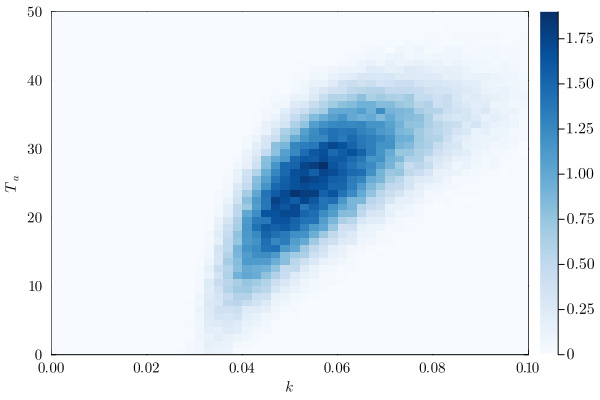

In [12]:
display(p2)

In [13]:
p31=histogram(Ta_accepted_samples[:],bins=(range(0,50,length=51)),show_empty_bins=true,color=:Blues,normalize=:pdf)
p31=plot!(xlims=(0,50),ylims=(0,0.06),xlabel=L"T_a",
    yticks=([0,0.02,0.04,0.06],[L"0.00", L"0.02", L"0.04", L"0.06"]),
    xticks=([0,10,20,30,40,50],[L"0", L"10", L"20", L"30",L"40",L"50"]),legend=false)
p32=histogram(k_accepted_samples[:],bins=(range(0,0.1,length=51)),show_empty_bins=true,color=:Blues,normalize=:pdf)
p32=plot!(xlims=(0,0.1),ylims=(0,40),xlabel=L"k",
    xticks=([0,0.02,0.04,0.06,0.08,0.10],[L"0.00", L"0.02", L"0.04", L"0.06",L"0.08",L"0.10"]),
    yticks=([0,10,20,30,40],[L"0", L"10", L"20", L"30",L"40"]),legend=false);

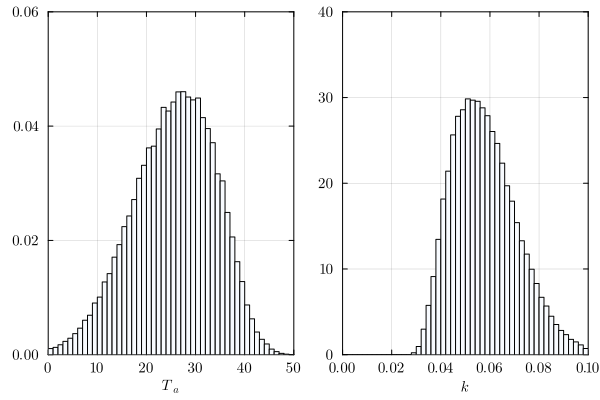

In [14]:
p3=plot(p31,p32,layout=(1,2))

In [15]:
# calculate the posterior using ABC with a range of thresholds to explore how the posterior changes
@time begin

    # initialise sampler variables
    ϵ=[3000.0 1500.0 750.0]
    number_samples=Int(1.0e5)
    
    Ta_accepted_samples_varyϵ=zeros(Float64,number_samples,length(ϵ))
    k_accepted_samples_varyϵ=zeros(Float64,number_samples,length(ϵ))

    for jj=1:length(ϵ)
        global ii=1
        while ii<=number_samples
            # sample from prior distribution
            Ta_accepted_samples_varyϵ[ii,jj]=rand(Uniform(0,Ta_max))
            k_accepted_samples_varyϵ[ii,jj]=rand(Uniform(0,k_max))
            # if model and data are sufficiently close, accept the sample into the posterior distribution
            if distance(data,T0,[Ta_accepted_samples_varyϵ[ii,jj],k_accepted_samples_varyϵ[ii,jj]],σ)<ϵ[jj]
                ii=ii+1
            end
        end
    end
    
end

LoadError: InterruptException:

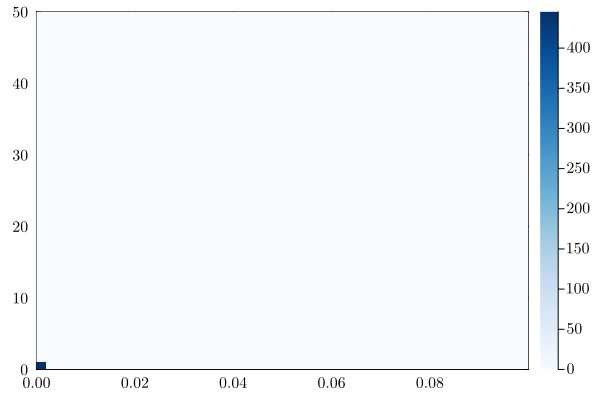

In [16]:
p41=histogram2d(k_accepted_samples_varyϵ[:,1],Ta_accepted_samples_varyϵ[:,1],
    bins=(range(0,0.1,length=51),range(0,50,length=51)),show_empty_bins=true,normalize=:pdf,color=:Blues)
p41=plot!(xlims=(0,0.1),ylims=(0,50),xlabel=L"k",ylabel=L"T_a",title=L"\epsilon=3000",
    xticks=([0,0.02,0.04,0.06,0.08,0.10],[L"0.00", L"0.02", L"0.04", L"0.06",L"0.08",L"0.10"]),
    yticks=([0,10,20,30,40,50],[L"0", L"10", L"20", L"30",L"40",L"50"]),legend=false)
p42=histogram2d(k_accepted_samples_varyϵ[:,2],Ta_accepted_samples_varyϵ[:,2],
    bins=(range(0,0.1,length=51),range(0,50,length=51)),show_empty_bins=true,normalize=:pdf,color=:Blues)
p42=plot!(xlims=(0,0.1),ylims=(0,50),xlabel=L"k",ylabel=L"T_a",title=L"\epsilon=1500",
    xticks=([0,0.02,0.04,0.06,0.08,0.10],[L"0.00", L"0.02", L"0.04", L"0.06",L"0.08",L"0.10"]),
    yticks=([0,10,20,30,40,50],[L"0", L"10", L"20", L"30",L"40",L"50"]),legend=false)
p43=histogram2d(k_accepted_samples_varyϵ[:,3],Ta_accepted_samples_varyϵ[:,3],
    bins=(range(0,0.1,length=51),range(0,50,length=51)),show_empty_bins=true,normalize=:pdf,color=:Blues)
p43=plot!(xlims=(0,0.1),ylims=(0,50),xlabel=L"k",ylabel=L"T_a",title=L"\epsilon=750",
    xticks=([0,0.02,0.04,0.06,0.08,0.10],[L"0.00", L"0.02", L"0.04", L"0.06",L"0.08",L"0.10"]),
    yticks=([0,10,20,30,40,50],[L"0", L"10", L"20", L"30",L"40",L"50"]),legend=false);

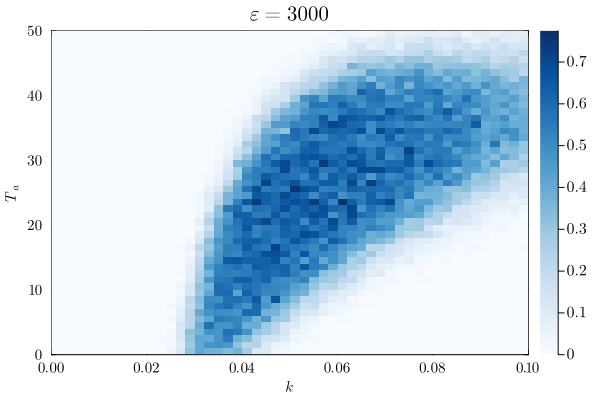

In [17]:
display(p41)

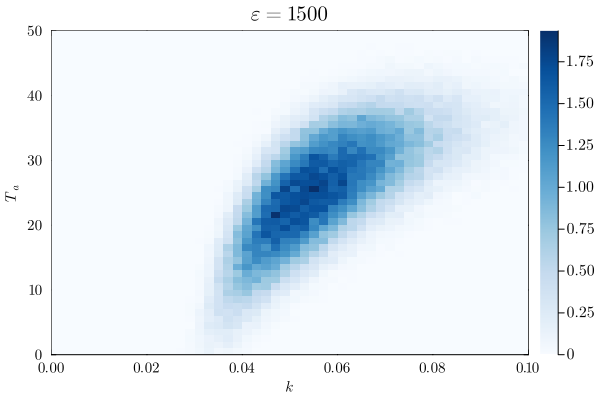

In [18]:
display(p42)

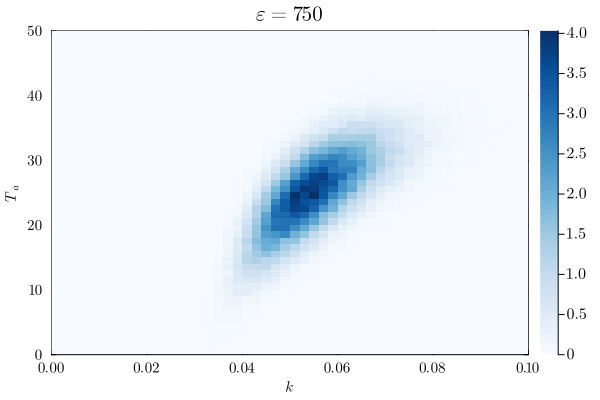

In [19]:
display(p43)

In [ ]:
# show how the prediction intervals change as the threshold \epsilon is varied
@time begin
    lower=10*Tamle*ones(length(tt))
    upper=zeros(length(tt))
    jj=1
    for ii=1:number_samples
        Ts(t)=Ta_accepted_samples_varyϵ[ii,jj]+(T0-Ta_accepted_samples_varyϵ[ii,jj])*exp(-k_accepted_samples_varyϵ[ii,jj]*t)
        for kk=1:length(tt)
            if Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[1] < lower[kk] 
                lower[kk] = Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[1]
            end
            if Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[2] > upper[kk] 
                upper[kk] = Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[2] 
            end   
        end
    end
    p51=scatter(t,data,mc=4,msc=:match,label=false)
    p51=plot!(tt,lower,lw=0,fillrange=upper,fillalpha=0.25,color=3,label=false,xlims=(tt[1]-1,tt[end]+1))
    p51=plot!(Tmle,tt[1],tt[end],lw=2,xlabel=L"t",ylabel=L"T(t)",lc=5,label=false,ylims=(0,200),title=L"\epsilon=3000")
    p51=plot!(xticks = ([0,25,50,75,100],[L"0", L"25", L"50", L"75", L"100"]))
    p51=plot!(yticks = ([0,50,100,150,200],[L"0",L"50",L"100",L"150",L"200"]));
    
    lower=10*Tamle*ones(length(tt))
    upper=zeros(length(tt))
    jj=2
    for ii=1:number_samples
        Ts(t)=Ta_accepted_samples_varyϵ[ii,jj]+(T0-Ta_accepted_samples_varyϵ[ii,jj])*exp(-k_accepted_samples_varyϵ[ii,jj]*t)
        for kk=1:length(tt)
            if Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[1] < lower[kk] 
                lower[kk] = Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[1]
            end
            if Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[2] > upper[kk] 
                upper[kk] = Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[2] 
            end   
        end
    end
    p52=scatter(t,data,mc=4,msc=:match,label=false)
    p52=plot!(tt,lower,lw=0,fillrange=upper,fillalpha=0.25,color=3,label=false,xlims=(tt[1]-1,tt[end]+1))
    p52=plot!(Tmle,tt[1],tt[end],lw=2,xlabel=L"t",ylabel=L"T(t)",lc=5,label=false,ylims=(0,200),title=L"\epsilon=1500")
    p52=plot!(xticks = ([0,25,50,75,100],[L"0", L"25", L"50", L"75", L"100"]))
    p52=plot!(yticks = ([0,50,100,150,200],[L"0",L"50",L"100",L"150",L"200"]));
    
    lower=10*Tamle*ones(length(tt))
    upper=zeros(length(tt))
    jj=3
    for ii=1:number_samples
        Ts(t)=Ta_accepted_samples_varyϵ[ii,jj]+(T0-Ta_accepted_samples_varyϵ[ii,jj])*exp(-k_accepted_samples_varyϵ[ii,jj]*t)
        for kk=1:length(tt)
            if Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[1] < lower[kk] 
                lower[kk] = Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[1]
            end
            if Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[2] > upper[kk] 
                upper[kk] = Ts(tt[kk])+quantile(Normal(0,σ),[0.05,0.95])[2] 
            end   
        end
    end
    p53=scatter(t,data,mc=4,msc=:match,label=false)
    p53=plot!(tt,lower,lw=0,fillrange=upper,fillalpha=0.25,color=3,label=false,xlims=(tt[1]-1,tt[end]+1))
    p53=plot!(Tmle,tt[1],tt[end],lw=2,xlabel=L"t",ylabel=L"T(t)",lc=5,label=false,ylims=(0,200),title=L"\epsilon=750")
    p53=plot!(xticks = ([0,25,50,75,100],[L"0", L"25", L"50", L"75", L"100"]))
    p53=plot!(yticks = ([0,50,100,150,200],[L"0",L"50",L"100",L"150",L"200"]));
end

In [ ]:
p5=plot(p51,p52,p53,layout=(1,3))